# Sampling Comparison

We can compare the differences in sampling the model of DynaQ and Trajectory sampling.

Consider the Slippery Walk Seven (SWS) environment

In [1]:
import numpy as np
import random

class Space:
    def __init__(self, value):
        self.n = value
    
class SlipperyWalk:
    def __init__(self):
        self.reset()

    def reset(self):
        self.observation_space = Space(9)
        self.action_space = Space(2)
        self._state = np.random.choice([1,2,3,4,5,6,7])
        self._done = False
        return self._state

    def step(self, action):
        if self._done: raise ValueError('Episode has terminated')
        if action not in [0, 1]: raise ValueError('Invalid action')
        
        if(action==0): direction = -1
        if(action==1): direction = 1
        
        direction_list = [direction, -direction, 0]
        true_direction = random.choices(direction_list, weights=(50, 17, 33), k=1)
        self._state += true_direction[0]
        
        reward = 0
        if self._state < 1: self._done = True
        if self._state > 7: self._done = True; reward = 1
        return self._state, reward, self._done, 0  # obs, rew, done

In [2]:
env = SlipperyWalk()

In [3]:
def decay_schedule(init_value, min_value, decay_ratio, max_steps, log_start=-2, log_base=10):
    decay_steps = int(max_steps * decay_ratio)
    rem_steps = max_steps - decay_steps
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

In [4]:
def dyna_q(env, gamma=1.0,
           init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5,
           init_epsilon=1.0, min_epsilon=0.1, epsilon_decay_ratio=0.9,
           n_planning=3, n_episodes=3000):
    
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track =[]
   
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    
    # create a function to keep track of the transition function
    # and another one to keep track of the reward signal.
    T_count = np.zeros((nS, nA, nS), dtype=int)
    R_model = np.zeros((nS, nA, nS), dtype=np.float64)
    T_track, R_track, planning_track = [], [], []
    
    select_action = lambda state, Q, epsilon: \
        np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes)
    
    # the episode loop
    for e in range(n_episodes):
                   
        state, done = env.reset(), False
        
        while not done:
                   
            # select the action, as in original Q-learning       
            action = select_action(state, Q, epsilons[e])
                   
            # step the environment and get the experience tuple
            next_state, reward, done, _ = env.step(action)

            # start learning the model! 
            # increment the transition count for the state-action-next_state triplet 
            T_count[state][action][next_state] += 1
            
            # calculate an incremental mean of the reward signal
            # and use it to learn the reward signal
            r_diff = reward - R_model[state][action][next_state]
            R_model[state][action][next_state] += (r_diff / T_count[state][action][next_state])

            # calculate the TD target as usual, Q-learning style 
            # (off-policy, using the max)
            td_target = reward + gamma * Q[next_state].max() * (not done)
            
            # and the TD error
            td_error = td_target - Q[state][action]
            
            # finally, update the Q-function
            Q[state][action] = Q[state][action] + alphas[e] * td_error

            # get into the planning steps, first back up the next state variable.       
            backup_next_state = next_state
            
            # planning loop
            for _ in range(n_planning):
                   
                # make sure there have been updates to the Q-function before, 
                # otherwise, there’s not much to plan
                if Q.sum() == 0: break

                # select a state from a list of states already visited by 
                # the agent in experience   
                visited_states = np.where(np.sum(T_count, axis=(1, 2)) > 0)[0]
                state = np.random.choice(visited_states)

                # then select an action that has been taken on that state.   
                actions_taken = np.where(np.sum(T_count[state], axis=1) > 0)[0]
                action = np.random.choice(actions_taken)

                # use the count matrix to calculate probabilities of a next state 
                # and then a next state   
                probs = T_count[state][action]/T_count[state][action].sum()
                next_state = np.random.choice(np.arange(nS), size=1, p=probs)[0]
                
                # use the reward model as the reward
                reward = R_model[state][action][next_state]
                planning_track.append((state, action, reward, next_state))

                # update the Q-function using that simulated experience!    
                td_target = reward + gamma * Q[next_state].max()
                td_error = td_target - Q[state][action]
                Q[state][action] = Q[state][action] + alphas[e] * td_error
            
            V = np.max(Q, axis=1)
            
            # at the end of the planning steps, set the state as the next state
            state = backup_next_state

        T_track.append(T_count.copy())
        R_track.append(R_model.copy())
        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, V_track, pi_track, T_track, R_track, np.array(planning_track)

In [5]:
_, _, _, _, _, _, _, _, planning_dq = dyna_q(env)

In [6]:
def trajectory_sampling(env, gamma=1.0,
                        init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5,
                        init_epsilon=1.0, min_epsilon=0.1, epsilon_decay_ratio=0.9,
                        max_trajectory_depth=100, planning_freq=5,
                        greedy_planning=True, n_episodes=2000):
            
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track =[]
   
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    
    T_count = np.zeros((nS, nA, nS), dtype=int)
    R_model = np.zeros((nS, nA, nS), dtype=np.float64)
    T_track, R_track, planning_track = [], [], []
    
    select_action = lambda state, Q, epsilon: \
        np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes)

    for e in range(n_episodes):
                   
        state, done = env.reset(), False

        while not done:
            action = select_action(state, Q, epsilons[e])
            next_state, reward, done, _ = env.step(action)
            
            T_count[state][action][next_state] += 1
            r_diff = reward - R_model[state][action][next_state]
            R_model[state][action][next_state] += (r_diff / T_count[state][action][next_state])

            td_target = reward + gamma * Q[next_state].max() * (not done)
            td_error = td_target - Q[state][action]
            Q[state][action] = Q[state][action] + alphas[e] * td_error
            
            backup_next_state = next_state

            if e % planning_freq == 0:
                
                # notice: start planning using max_trajectory_depth variable
                # insted of n_planning
                for _ in range(max_trajectory_depth):
                    if Q.sum() == 0: break

                    # select the action either on-policy or off-policy 
                    action = Q[state].argmax() if greedy_planning else \
                        select_action(state, Q, epsilons[e])
                    
                    # if we haven’t experienced the transition, 
                    # planning would be a mess, so break out
                    if not T_count[state][action].sum(): break

                    # otherwise, get the probabilities of next_state and sample 
                    # the model accordingly, as in DynaQ
                    probs = T_count[state][action]/T_count[state][action].sum()
                    next_state = np.random.choice(np.arange(nS), size=1, p=probs)[0]
                    
                    # get the reward as prescribed by the reward-signal model, as in DynaQ
                    reward = R_model[state][action][next_state]
                    planning_track.append((state, action, reward, next_state))

                    
                    # continue updating the Q-function as if with real experience, as in DynaQ
                    td_target = reward + gamma * Q[next_state].max()
                    td_error = td_target - Q[state][action]
                    Q[state][action] = Q[state][action] + alphas[e] * td_error

                    # notice: we update the state variable before we loop and 
                    # continue the on-policy planning steps
                    state = next_state

            V = np.max(Q, axis=1)
            
            # outside the planning loop, we restore the state, 
            # and continue real interaction steps
            state = backup_next_state

        T_track.append(T_count.copy())
        R_track.append(R_model.copy())
        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, V_track, pi_track, T_track, R_track, np.array(planning_track)

In [7]:
_, _, _, _, _, _, _, _, planning_ts = trajectory_sampling(env)

We can plot the states that were sampled by the planning phase of the two algorithms and the actions selected in those states. 

In [8]:
import matplotlib.pyplot as plt

def plot_model_state_sampling(planning, algo):
    plt.figure(figsize=(10,5))
    color_left, color_right = '#008fd5', '#fc4f30'
    
    for s in np.arange(9):
        actions = planning[np.where(planning[:,0]==s)[0], 1]
        left = len(actions[actions == 0])
        right = len(actions[actions == 1])
        plt.bar(s, right, 0.2, color=color_right)
        plt.bar(s, left, 0.2, color=color_left, bottom=right)
    
    plt.title('States samples from {}\nlearned model of SWS environment'.format(algo))
    plt.xlabel('Initial states sampled',)
    plt.ylabel('Count')
    plt.legend(['Right', 'Left'])
    plt.show()

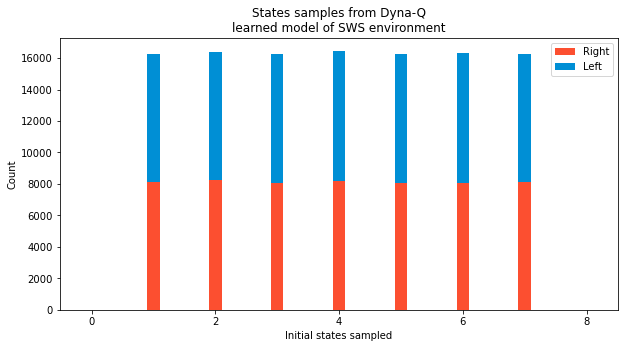

In [9]:
plot_model_state_sampling(planning_dq, algo='Dyna-Q')

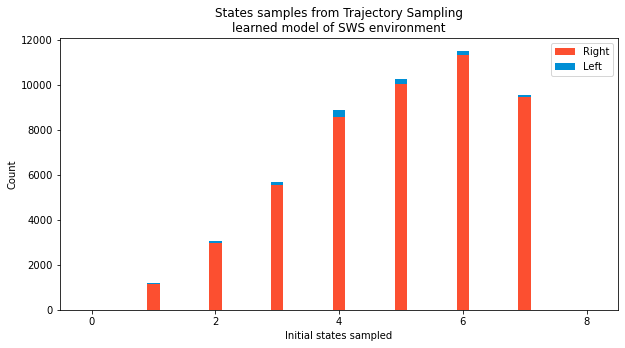

In [10]:
plot_model_state_sampling(planning_ts, algo='Trajectory Sampling')